# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.

We'll go through the following steps:
* Create a dataset for training and testing
* Use MONAI transforms to pre-process data
* Use the DenseNet from MONAI for classification
* Train the model with a PyTorch program
* Evaluate on test dataset


Reference 
https://github.com/Project-MONAI/tutorials/tree/master/2d_classification 

## Setup environment

In [1]:
#!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib
#%matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import gdown
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import utils
import pandas as pd
import seaborn as sns

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.3.1
TorchVision version: 0.10.0a0
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.4.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
#root_dir = '$HOME/datasets/medNIST' ## ALTERNATIVELY
print(root_dir)


/home/mx19/datasets/monai/


## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [4]:
resource = "https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

# RuntimeError: Download of file from https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE to /tmp/tmpx8vbjqyo/MedNIST.tar.gz failed due to network issue or denied permission.
## DOWNLOAD IT MANUALLY
# data_dir = os.path.join(root_dir, "MedNIST")

## Set deterministic training for reproducibility

In [5]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [6]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

0 2732
1 43567
2 42613
3 52416
4 45891
5 21243
6 30403
7 32103
8 41993
9 57043
10 20757
11 55026
12 46884
13 14935
14 15430
15 48600


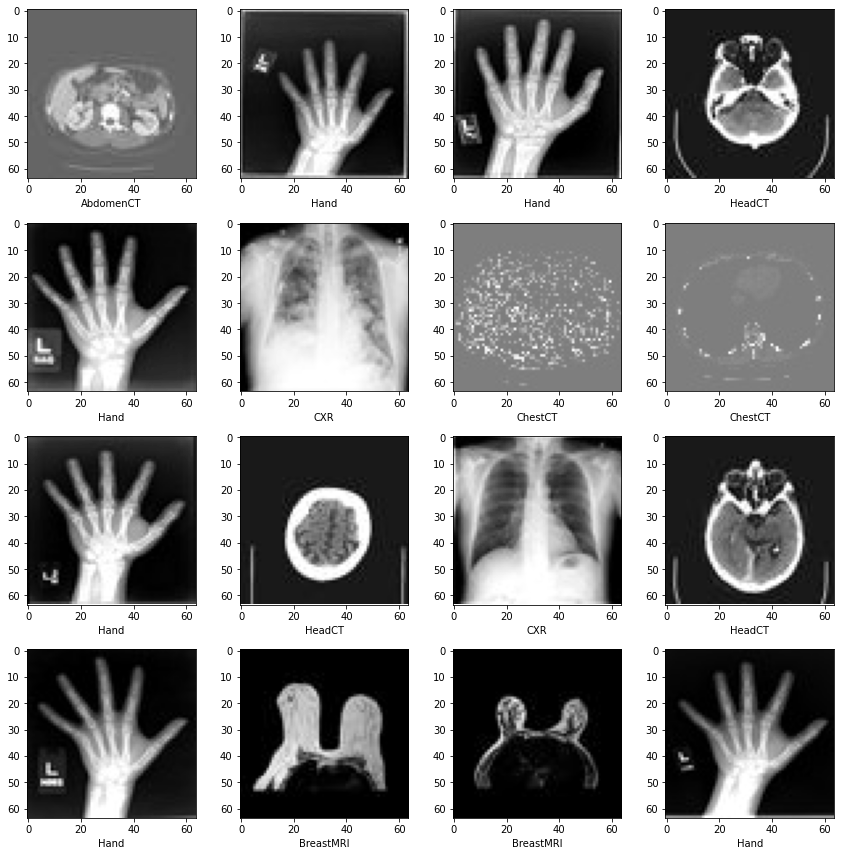

In [7]:
plt.subplots(4, 4, figsize=(12, 12))
for i, k in enumerate(np.random.randint(num_total, size=16)):
    print(i,k)
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(4, 4, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [8]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [9]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

       ----------------------------------------------------------
       Grid size torch.Size([3, 2510, 530])


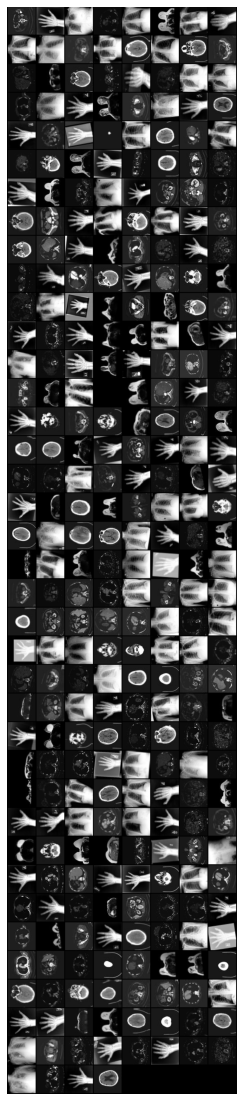

       ----------------------------------------------------------
       Grid size torch.Size([3, 2510, 530])


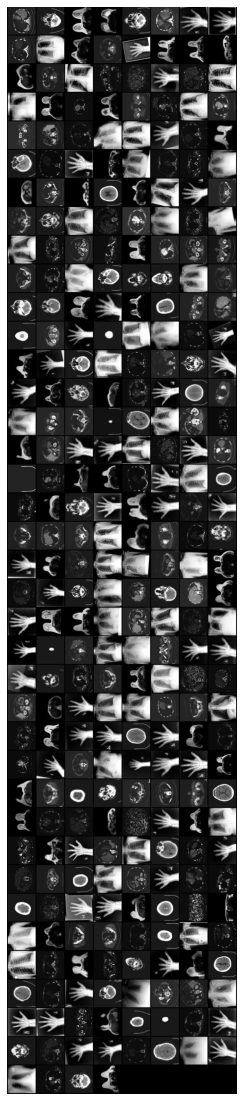

In [10]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms) # returning mage_files[index] and labels[index]
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)  # returning mage_files[index] and labels[index]
#print(val_ds.__len__()) #5895
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
#print(test_ds.__len__()) #5895
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=300, num_workers=10)


#print(train_ds.__len__()) #47164
#print(  train_ds.__getitem__(47163)   )
#print(len(train_loader.dataset))#47164


for batch_idx, sample_batched in enumerate(train_loader):
    
    if batch_idx <= 1:
        print(f'       ----------------------------------------------------------')
        #print(f'       BATCH_INDEX: {batch_idx} SAMPLE_IDX_LABELS: {sample_batched[1]}')
        sample_batched_labels=sample_batched[1]
        #print(sample_batched_labels.shape) #torch.Size([batch_size])
        sample_batched=sample_batched[0]
        #print(batch_image.shape) #torch.Size([batch_size, 1, 64, 64])

        plt.figure(figsize =(20,20) )
        plt.tight_layout()
        grid = utils.make_grid(sample_batched)
        print(f'       Grid size {grid.size()}' )
        plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
        #plt.title(f'Batch from dataloader {i_batch}; Label: {labelnames[data_clip_label]}')
        plt.axis('off')
        plt.ioff()
        plt.show()

    
    

## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}')
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

DEVICE: cuda


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [12]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        #print(inputs.size())#torch.Size([300, 1, 64, 64])
        #print(labels.size())#torch.Size([300])
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs.size()) #torch.Size([300, 6])
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(train_loader.batch_size)#300
        print(
            f"  Batch_step = {step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            #print(y_pred.size())#torch.Size([0])
            y = torch.tensor([], dtype=torch.long, device=device)
            #print(y.size())#torch.Size([0])
            for val_data in val_loader:
                val_images, val_labels = (val_data[0].to(device), val_data[1].to(device))
                #print(val_images.size())#torch.Size([300, 1, 64, 64])...;torch.Size([195, 1, 64, 64])
                #print(val_labels.size())#torch.Size([300])...;torch.Size([195])
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                #print(y_pred.size())#torch.Size([300, 6])....torch.Size([5895, 6])
                y = torch.cat([y, val_labels], dim=0)
                #print(y.size())#torch.Size([300])....torch.Size([5895])
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            #print(len(y_onehot))#5895
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            #print(len(y_pred_act))#5895
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/10
  Batch_step = 1/157, train_loss: 1.7916
  Batch_step = 2/157, train_loss: 1.7655
  Batch_step = 3/157, train_loss: 1.7226
  Batch_step = 4/157, train_loss: 1.7274
  Batch_step = 5/157, train_loss: 1.7297
  Batch_step = 6/157, train_loss: 1.7030
  Batch_step = 7/157, train_loss: 1.6610
  Batch_step = 8/157, train_loss: 1.6362
  Batch_step = 9/157, train_loss: 1.6141
  Batch_step = 10/157, train_loss: 1.5653
  Batch_step = 11/157, train_loss: 1.5387
  Batch_step = 12/157, train_loss: 1.5278
  Batch_step = 13/157, train_loss: 1.4983
  Batch_step = 14/157, train_loss: 1.4969
  Batch_step = 15/157, train_loss: 1.4571
  Batch_step = 16/157, train_loss: 1.4705
  Batch_step = 17/157, train_loss: 1.4054
  Batch_step = 18/157, train_loss: 1.4060
  Batch_step = 19/157, train_loss: 1.3740
  Batch_step = 20/157, train_loss: 1.4007
  Batch_step = 21/157, train_loss: 1.3525
  Batch_step = 22/157, train_loss: 1.3178
  Batch_step = 23/157, train_loss: 1.3042
  Batch_step = 24/157

  Batch_step = 33/157, train_loss: 0.1607
  Batch_step = 34/157, train_loss: 0.1939
  Batch_step = 35/157, train_loss: 0.2000
  Batch_step = 36/157, train_loss: 0.1512
  Batch_step = 37/157, train_loss: 0.1818
  Batch_step = 38/157, train_loss: 0.1762
  Batch_step = 39/157, train_loss: 0.1613
  Batch_step = 40/157, train_loss: 0.1625
  Batch_step = 41/157, train_loss: 0.1788
  Batch_step = 42/157, train_loss: 0.1462
  Batch_step = 43/157, train_loss: 0.2013
  Batch_step = 44/157, train_loss: 0.1712
  Batch_step = 45/157, train_loss: 0.1477
  Batch_step = 46/157, train_loss: 0.1703
  Batch_step = 47/157, train_loss: 0.1498
  Batch_step = 48/157, train_loss: 0.1689
  Batch_step = 49/157, train_loss: 0.1513
  Batch_step = 50/157, train_loss: 0.1865
  Batch_step = 51/157, train_loss: 0.1533
  Batch_step = 52/157, train_loss: 0.1321
  Batch_step = 53/157, train_loss: 0.1894
  Batch_step = 54/157, train_loss: 0.1625
  Batch_step = 55/157, train_loss: 0.1358
  Batch_step = 56/157, train_loss:

  Batch_step = 65/157, train_loss: 0.0687
  Batch_step = 66/157, train_loss: 0.0753
  Batch_step = 67/157, train_loss: 0.0630
  Batch_step = 68/157, train_loss: 0.0757
  Batch_step = 69/157, train_loss: 0.0564
  Batch_step = 70/157, train_loss: 0.0888
  Batch_step = 71/157, train_loss: 0.0721
  Batch_step = 72/157, train_loss: 0.0779
  Batch_step = 73/157, train_loss: 0.0769
  Batch_step = 74/157, train_loss: 0.0584
  Batch_step = 75/157, train_loss: 0.0794
  Batch_step = 76/157, train_loss: 0.0482
  Batch_step = 77/157, train_loss: 0.0548
  Batch_step = 78/157, train_loss: 0.0505
  Batch_step = 79/157, train_loss: 0.0615
  Batch_step = 80/157, train_loss: 0.0632
  Batch_step = 81/157, train_loss: 0.0600
  Batch_step = 82/157, train_loss: 0.0625
  Batch_step = 83/157, train_loss: 0.0534
  Batch_step = 84/157, train_loss: 0.0501
  Batch_step = 85/157, train_loss: 0.0727
  Batch_step = 86/157, train_loss: 0.0599
  Batch_step = 87/157, train_loss: 0.0604
  Batch_step = 88/157, train_loss:

  Batch_step = 97/157, train_loss: 0.0257
  Batch_step = 98/157, train_loss: 0.0439
  Batch_step = 99/157, train_loss: 0.0358
  Batch_step = 100/157, train_loss: 0.0332
  Batch_step = 101/157, train_loss: 0.0225
  Batch_step = 102/157, train_loss: 0.0440
  Batch_step = 103/157, train_loss: 0.0393
  Batch_step = 104/157, train_loss: 0.0343
  Batch_step = 105/157, train_loss: 0.0236
  Batch_step = 106/157, train_loss: 0.0440
  Batch_step = 107/157, train_loss: 0.0405
  Batch_step = 108/157, train_loss: 0.0416
  Batch_step = 109/157, train_loss: 0.0277
  Batch_step = 110/157, train_loss: 0.0380
  Batch_step = 111/157, train_loss: 0.0337
  Batch_step = 112/157, train_loss: 0.0221
  Batch_step = 113/157, train_loss: 0.0508
  Batch_step = 114/157, train_loss: 0.0233
  Batch_step = 115/157, train_loss: 0.0235
  Batch_step = 116/157, train_loss: 0.0376
  Batch_step = 117/157, train_loss: 0.0354
  Batch_step = 118/157, train_loss: 0.0204
  Batch_step = 119/157, train_loss: 0.0304
  Batch_step =

  Batch_step = 129/157, train_loss: 0.0201
  Batch_step = 130/157, train_loss: 0.0316
  Batch_step = 131/157, train_loss: 0.0203
  Batch_step = 132/157, train_loss: 0.0253
  Batch_step = 133/157, train_loss: 0.0269
  Batch_step = 134/157, train_loss: 0.0212
  Batch_step = 135/157, train_loss: 0.0184
  Batch_step = 136/157, train_loss: 0.0132
  Batch_step = 137/157, train_loss: 0.0148
  Batch_step = 138/157, train_loss: 0.0239
  Batch_step = 139/157, train_loss: 0.0263
  Batch_step = 140/157, train_loss: 0.0325
  Batch_step = 141/157, train_loss: 0.0120
  Batch_step = 142/157, train_loss: 0.0194
  Batch_step = 143/157, train_loss: 0.0229
  Batch_step = 144/157, train_loss: 0.0241
  Batch_step = 145/157, train_loss: 0.0182
  Batch_step = 146/157, train_loss: 0.0421
  Batch_step = 147/157, train_loss: 0.0211
  Batch_step = 148/157, train_loss: 0.0217
  Batch_step = 149/157, train_loss: 0.0187
  Batch_step = 150/157, train_loss: 0.0279
  Batch_step = 151/157, train_loss: 0.0309
  Batch_ste

  Batch_step = 1/157, train_loss: 0.0236
  Batch_step = 2/157, train_loss: 0.0224
  Batch_step = 3/157, train_loss: 0.0173
  Batch_step = 4/157, train_loss: 0.0190
  Batch_step = 5/157, train_loss: 0.0161
  Batch_step = 6/157, train_loss: 0.0173
  Batch_step = 7/157, train_loss: 0.0141
  Batch_step = 8/157, train_loss: 0.0194
  Batch_step = 9/157, train_loss: 0.0158
  Batch_step = 10/157, train_loss: 0.0097
  Batch_step = 11/157, train_loss: 0.0316
  Batch_step = 12/157, train_loss: 0.0132
  Batch_step = 13/157, train_loss: 0.0083
  Batch_step = 14/157, train_loss: 0.0151
  Batch_step = 15/157, train_loss: 0.0257
  Batch_step = 16/157, train_loss: 0.0121
  Batch_step = 17/157, train_loss: 0.0127
  Batch_step = 18/157, train_loss: 0.0130
  Batch_step = 19/157, train_loss: 0.0171
  Batch_step = 20/157, train_loss: 0.0147
  Batch_step = 21/157, train_loss: 0.0165
  Batch_step = 22/157, train_loss: 0.0185
  Batch_step = 23/157, train_loss: 0.0111
  Batch_step = 24/157, train_loss: 0.0206
 

  Batch_step = 35/157, train_loss: 0.0105
  Batch_step = 36/157, train_loss: 0.0073
  Batch_step = 37/157, train_loss: 0.0109
  Batch_step = 38/157, train_loss: 0.0135
  Batch_step = 39/157, train_loss: 0.0164
  Batch_step = 40/157, train_loss: 0.0138
  Batch_step = 41/157, train_loss: 0.0082
  Batch_step = 42/157, train_loss: 0.0110
  Batch_step = 43/157, train_loss: 0.0075
  Batch_step = 44/157, train_loss: 0.0126
  Batch_step = 45/157, train_loss: 0.0156
  Batch_step = 46/157, train_loss: 0.0106
  Batch_step = 47/157, train_loss: 0.0068
  Batch_step = 48/157, train_loss: 0.0075
  Batch_step = 49/157, train_loss: 0.0065
  Batch_step = 50/157, train_loss: 0.0059
  Batch_step = 51/157, train_loss: 0.0068
  Batch_step = 52/157, train_loss: 0.0188
  Batch_step = 53/157, train_loss: 0.0160
  Batch_step = 54/157, train_loss: 0.0124
  Batch_step = 55/157, train_loss: 0.0106
  Batch_step = 56/157, train_loss: 0.0111
  Batch_step = 57/157, train_loss: 0.0138
  Batch_step = 58/157, train_loss:

  Batch_step = 67/157, train_loss: 0.0053
  Batch_step = 68/157, train_loss: 0.0181
  Batch_step = 69/157, train_loss: 0.0108
  Batch_step = 70/157, train_loss: 0.0050
  Batch_step = 71/157, train_loss: 0.0211
  Batch_step = 72/157, train_loss: 0.0048
  Batch_step = 73/157, train_loss: 0.0070
  Batch_step = 74/157, train_loss: 0.0083
  Batch_step = 75/157, train_loss: 0.0106
  Batch_step = 76/157, train_loss: 0.0057
  Batch_step = 77/157, train_loss: 0.0066
  Batch_step = 78/157, train_loss: 0.0067
  Batch_step = 79/157, train_loss: 0.0057
  Batch_step = 80/157, train_loss: 0.0059
  Batch_step = 81/157, train_loss: 0.0056
  Batch_step = 82/157, train_loss: 0.0084
  Batch_step = 83/157, train_loss: 0.0144
  Batch_step = 84/157, train_loss: 0.0067
  Batch_step = 85/157, train_loss: 0.0062
  Batch_step = 86/157, train_loss: 0.0161
  Batch_step = 87/157, train_loss: 0.0057
  Batch_step = 88/157, train_loss: 0.0056
  Batch_step = 89/157, train_loss: 0.0062
  Batch_step = 90/157, train_loss:

  Batch_step = 99/157, train_loss: 0.0046
  Batch_step = 100/157, train_loss: 0.0038
  Batch_step = 101/157, train_loss: 0.0054
  Batch_step = 102/157, train_loss: 0.0059
  Batch_step = 103/157, train_loss: 0.0047
  Batch_step = 104/157, train_loss: 0.0074
  Batch_step = 105/157, train_loss: 0.0041
  Batch_step = 106/157, train_loss: 0.0080
  Batch_step = 107/157, train_loss: 0.0057
  Batch_step = 108/157, train_loss: 0.0074
  Batch_step = 109/157, train_loss: 0.0056
  Batch_step = 110/157, train_loss: 0.0046
  Batch_step = 111/157, train_loss: 0.0037
  Batch_step = 112/157, train_loss: 0.0050
  Batch_step = 113/157, train_loss: 0.0051
  Batch_step = 114/157, train_loss: 0.0066
  Batch_step = 115/157, train_loss: 0.0067
  Batch_step = 116/157, train_loss: 0.0038
  Batch_step = 117/157, train_loss: 0.0046
  Batch_step = 118/157, train_loss: 0.0042
  Batch_step = 119/157, train_loss: 0.0055
  Batch_step = 120/157, train_loss: 0.0089
  Batch_step = 121/157, train_loss: 0.0044
  Batch_step

## Plot the loss and metric

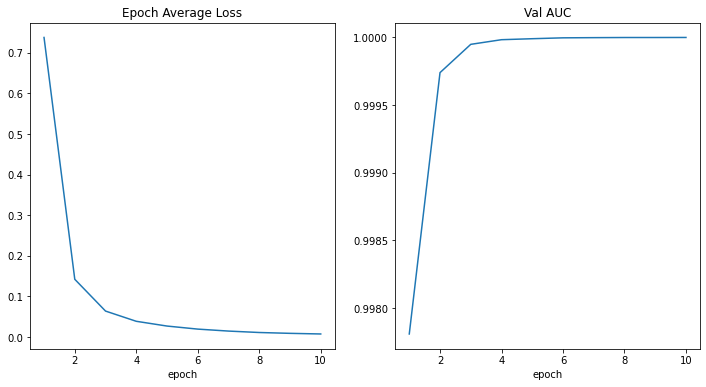

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [14]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [15]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   AbdomenCT     1.0000    0.9960    0.9980       988
   BreastMRI     1.0000    0.9989    0.9994       888
         CXR     1.0000    0.9980    0.9990       991
     ChestCT     0.9970    1.0000    0.9985       999
        Hand     0.9980    1.0000    0.9990      1003
      HeadCT     0.9981    1.0000    0.9990      1026

    accuracy                         0.9988      5895
   macro avg     0.9988    0.9988    0.9988      5895
weighted avg     0.9988    0.9988    0.9988      5895

[[ 984    0    0    2    0    2]
 [   0  887    0    1    0    0]
 [   0    0  989    0    2    0]
 [   0    0    0  999    0    0]
 [   0    0    0    0 1003    0]
 [   0    0    0    0    0 1026]]


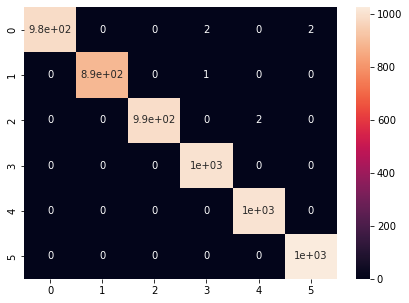

In [16]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred))
#.rename(columns=class_names, index=[0,1,2,3,4,5])

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()



## Cleanup data directory

Remove directory if a temporary was used.

In [17]:
if directory is None:
    shutil.rmtree(root_dir)